In [489]:
from scipy.optimize import curve_fit,minimize
from analysis.calc import dbgauss
from analysis.import_data import import_data,filter_data,combine_columns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [486]:
data_root = ""

In [487]:
mcp_raw = import_data(data_root + "npy/mcparticle/compare_mcparticle.npy")
reco_raw = import_data(data_root + "npy/reco/compare_reco.npy")
tjmr_raw = import_data(data_root + "npy/truejet_matchingreco/compare_truejet_matchingreco.npy")
tjt_raw = import_data(data_root + "npy/truejet_true/compare_truejet_true.npy")
tjs_raw = import_data(data_root + "npy/truejet_seen/compare_truejet_seen.npy")

In [488]:
data = {
    "mcp": filter_data(mcp_raw),
    "reco": filter_data(reco_raw),
    "tjmr": filter_data(tjmr_raw),
    "tjt": filter_data(tjt_raw),
    "tjs": filter_data(tjs_raw)
}

In [85]:
i = 1
reco = data["reco"][((data["reco"]["jet{}_e".format(i)] > 0) & (data["key"]["parton{}_e".format(i)] > 0))]

<Axes: xlabel='parton1_e', ylabel='Count'>

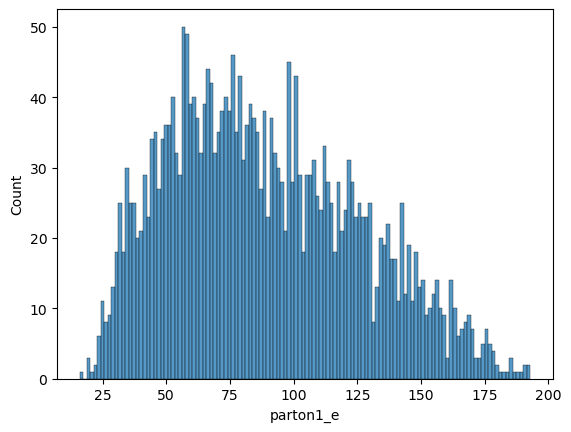

In [86]:
sns.histplot(reco, x="parton{}_e".format(i), bins=128)

In [490]:
def dbgauss(a, b, E_jet, E_part, JES):
    # Inspired by https://journals.aps.org/prd/abstract/10.1103/PhysRevD.74.092005
    
    """_summary_

    Args:
        a (_type_): _description_
        b (_type_): _description_
        E_jet (_type_): _description_
        E_part (_type_): _description_
        JES (float, optional): Jet energy scale. Defaults to 1.

    Returns:
        _type_: _description_
    """
    
    # Parametization according to thesis https://inspirehep.net/files/b8064e6fd21931e696b7b91410462128
    p1 = a[0] + b[0]*E_part
    p2 = a[1] + b[1]*E_part
    p3 = a[2] + b[2]*E_part
    p4 = a[3] + b[3]*E_part
    p5 = a[4] + b[4]*E_part
    # or: p = a + b*E_Part
    
    E_jet = E_jet/JES
    
    dE = E_jet - E_part
    
    return 1/(np.sqrt(2*np.pi)*(p2+p3*p5)) * (
             np.exp( -((dE-p1)**2)/(2*p2**2) ) +
        p3 * np.exp( -((dE-p4)**2)/(2*p5**2) )
    )
    
def dbgauss_wrapped(X, *args):
    E_jet, E_part = X
    a = [args[0], args[1], 0, args[2], args[3]]
    #a = args[0:5]
    b = args[4:9]
    JES = 1
    
    return dbgauss(a, b, E_jet, E_part, JES)    

def wrapper_fit_func(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
    return fit_func(x, a, b, c, N)

In [491]:
result.x

array([-1.72788203e+00,  5.67260995e+00,  5.90290734e-04,  3.38810511e+01,
       -1.65086033e-03,  1.35233869e-02,  1.55740745e-03, -1.54224121e-01,
       -2.74838529e-02])

In [329]:
res = dbgauss_wrapped((E_j, E_p), 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 1)
-np.log(res).sum()

19223.14

In [384]:
initial_guess = [1, 1, 1, 1,  1, 1, 1, 1, 1]

In [385]:
f([0, 0, 1, 1,       1, 1, 1, 1, 1])

16227.839

In [471]:
np.random.rand(3)

array([0.43808949, 0.92400248, 0.39735983])

In [540]:
def make_guess():
    rand = -1+2*np.random.rand(9)
    return [rand[0]*9, rand[1]*9, rand[2], rand[3]*3,   rand[4], rand[5], rand[6], rand[7], rand[8]]

In [480]:
a = (1,2,3,4)
b = (1,2,3,4,5)
c = (1,2,3,4,1,2,3,4,5)
dbgauss_wrapped((1, 2), *c)

0.021969101319215076

In [541]:
def fit_jet(data, i, guess=None):
    reco = data["reco"][((data["reco"]["jet{}_e".format(i)] > 0) & (data["reco"]["parton{}_e".format(i)] > 0))]
    
    E_j = reco["jet{}_e".format(i)]; E_j.reset_index(drop=True, inplace=True)
    E_p = reco["parton{}_e".format(i)]; E_p.reset_index(drop=True, inplace=True)
    
    def f(args):
        a = [args[0], args[1], 0, args[2], args[3]] 
        b = args[4:9]
        #JES = args[10]
        JES = 1
        
        return -np.log(dbgauss(a, b, E_j, E_p, JES)).sum()    
    
    lowest = 9999
    n_iter = 1 if guess is not None else 100
    result = None
    for j in range(n_iter):
        c_result = minimize(f, x0=(guess if guess is not None else make_guess()), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})
        if c_result.fun < lowest and c_result.fun > 0.1:
            result = c_result
            lowest = c_result.fun
    
    h, xedges, yedges, _ = plt.hist2d(E_j, E_p, bins=(32,32))

    #bins_j = np.histogram_bin_edges(E_j, bins=32)
    bincs_j = xedges[:-1] + np.diff(xedges) / 2

    #bins_p = np.histogram_bin_edges(E_p, bins=32)
    bincs_p = yedges[:-1] + np.diff(yedges) / 2
    
    plt.close()
    
    # Plot data
    plt.imshow(h/h.sum().sum(), origin="lower", extent=(E_j.min(), E_j.max(), E_p.min(), E_p.max()))
    plt.colorbar()
    plt.suptitle("Data")
    plt.show()
    
    Z = []
    for E in bincs_p:
        Z.append(dbgauss_wrapped((bincs_j, E*np.ones(len(bincs_j)), ), *result.x))
    Z = np.array(Z)
    
    # Plot fit
    plt.imshow(Z/Z.sum().sum(), origin="lower", extent=(bincs_j.min(), bincs_j.max(), bincs_p.min(), bincs_p.max()))
    plt.colorbar()
    plt.suptitle("Fit")
    plt.show()
    
    # Plot comparison
    plt.imshow(np.abs(Z/Z.sum().sum()-h/h.sum().sum()), origin="lower", extent=(bincs_j.min(), bincs_j.max(), bincs_p.min(), bincs_p.max()))
    plt.colorbar()
    plt.suptitle("Diff")
    plt.show()
    
    return result

def fit_jet_binned(data, i):
    
    # Get data
    reco = data["reco"][((data["reco"]["jet{}_e".format(i)] > 0) & (data["reco"]["parton{}_e".format(i)] > 0))]
    
    initial_guess = [-5.08e-0, 3.8e0, 2.23e-4, 1.12e1,    2.4e-3, 8.7e-2, 2.12e-3, -1.81e-1, 1.12e-1]
    
    E_j = reco["jet{}_e".format(i)]; E_j.reset_index(drop=True, inplace=True)
    E_p = reco["parton{}_e".format(i)]; E_p.reset_index(drop=True, inplace=True)
    
    # Create hist    
    h, xedges, yedges, _ = plt.hist2d(E_j, E_p, bins=(32,32))
    bincs_j = (xedges[:-1] + xedges[1:]) / 2
    bincs_p = (yedges[:-1] + yedges[1:]) / 2
    
    plt.close()
    
    # Normalize bins
    h = h/h.sum().sum()
    
    def f_binned(args):
        a = [args[0], args[1], 0, args[2], args[3]] 
        b = args[4:9]
        #JES = args[10]
        JES = 1
        
        # Predict data at bin centers
        Z = []
        for E in bincs_p:
            Z.append(dbgauss(a, b, bincs_j, E*np.ones(len(bincs_j)), JES))
        Z = np.array(Z)
        Z = Z/Z.sum().sum()
        
        return (((Z-h)**2).sum().sum())
        
        #return -np.log(dbgauss(a, b, E_j, E_p, JES)).sum()
        
    
    lowest = 9999
    n_iter = 50
    result = None
    for j in range(n_iter):
        c_result = minimize(f_binned, x0=make_guess(), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})

        if c_result.fun < lowest and c_result.fun > 0.0001:
            result = c_result
            lowest = c_result.fun
    
    # Plot data
    plt.imshow(h, origin="lower", extent=(E_j.min(), E_j.max(), E_p.min(), E_p.max()))
    plt.colorbar()
    plt.suptitle("Data")
    plt.show()
    
    Z = []
    for E in bincs_p:
        Z.append(dbgauss_wrapped((bincs_j, E*np.ones(len(bincs_j)), ), *result.x))
    Z = np.array(Z)
    
    # Plot fit
    plt.imshow(Z/Z.sum().sum(), origin="lower", extent=(bincs_j.min(), bincs_j.max(), bincs_p.min(), bincs_p.max()))
    plt.colorbar()
    plt.suptitle("Fit")
    plt.show()
    
    # Plot comparison
    plt.imshow(np.abs(Z/Z.sum().sum()-h), origin="lower", extent=(bincs_j.min(), bincs_j.max(), bincs_p.min(), bincs_p.max()))
    plt.colorbar()
    plt.suptitle("Diff")
    plt.show()
    
    return result

Optimization terminated successfully.
         Current function value: 0.001250
         Iterations: 1086
         Function evaluations: 1628
Optimization terminated successfully.
         Current function value: 0.000858
         Iterations: 1277
         Function evaluations: 1888
Optimization terminated successfully.
         Current function value: 0.001388
         Iterations: 2894
         Function evaluations: 4200
Optimization terminated successfully.
         Current function value: 0.001953
         Iterations: 3733
         Function evaluations: 5373


C:\Users\Bryan Bliewert\AppData\Local\Temp\ipykernel_4988\60671257.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  c_result = minimize(f_binned, x0=make_guess(), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.002486
         Iterations: 1673
         Function evaluations: 2454
Optimization terminated successfully.
         Current function value: 0.001560
         Iterations: 1586
         Function evaluations: 2341
Optimization terminated successfully.
         Current function value: 0.002461
         Iterations: 1982
         Function evaluations: 2916
Optimization terminated successfully.
         Current function value: 0.000983
         Iterations: 3285
         Function evaluations: 4780
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 3323
         Function evaluations: 4894
Optimization terminated successfully.
         Current function value: 0.001518
         Iterations: 2120
         Function evaluations: 3097
Optimization terminated successfully.
         Current function value: 0.000764
         Iterations: 1428
         Function evaluations: 2130
Optimi

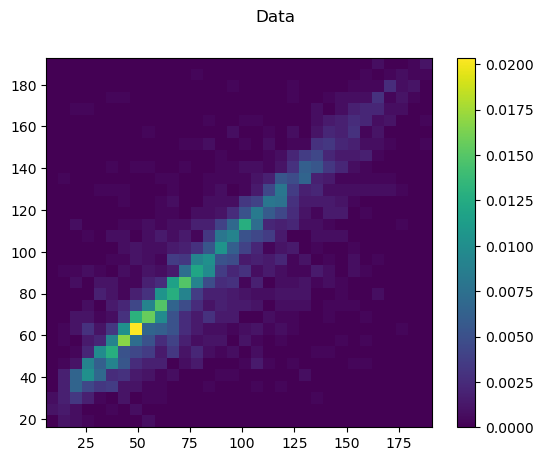

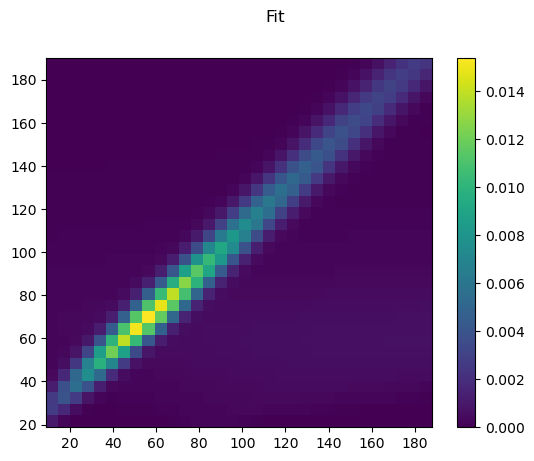

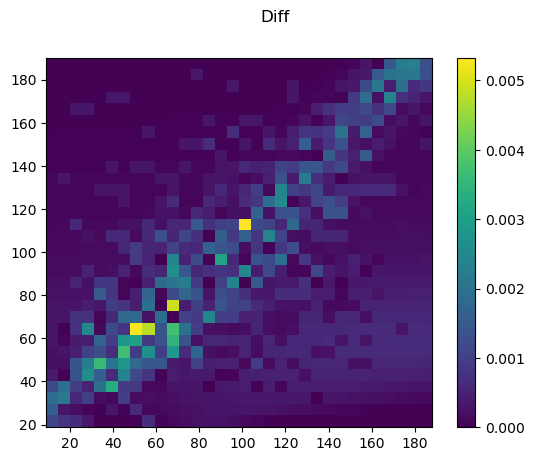

In [542]:
res1 = fit_jet_binned(data, 1)
good1 = res1.x.copy()

Optimization terminated successfully.
         Current function value: 0.000734
         Iterations: 1441
         Function evaluations: 2107


C:\Users\Bryan Bliewert\AppData\Local\Temp\ipykernel_4988\1326134499.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  c_result = minimize(f_binned, x0=make_guess(), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.002472
         Iterations: 1297
         Function evaluations: 1949
Optimization terminated successfully.
         Current function value: 0.002345
         Iterations: 2241
         Function evaluations: 3620
Optimization terminated successfully.
         Current function value: 0.003506
         Iterations: 2168
         Function evaluations: 3242
Optimization terminated successfully.
         Current function value: 0.001841
         Iterations: 2393
         Function evaluations: 3820
Optimization terminated successfully.
         Current function value: 0.001907
         Iterations: 2290
         Function evaluations: 3373
Optimization terminated successfully.
         Current function value: 0.001146
         Iterations: 1589
         Function evaluations: 2340
Optimization terminated successfully.
         Current function value: 0.002340
         Iterations: 2409
         Function evaluations: 3483


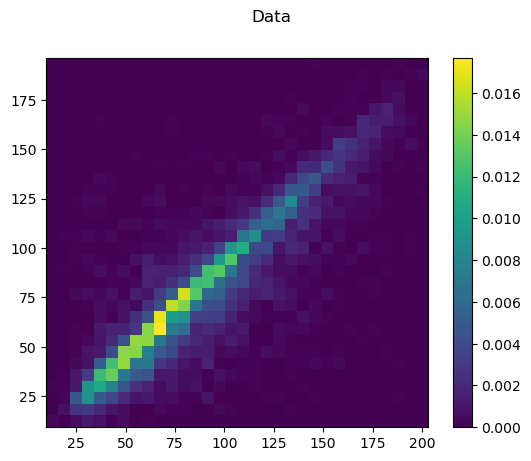

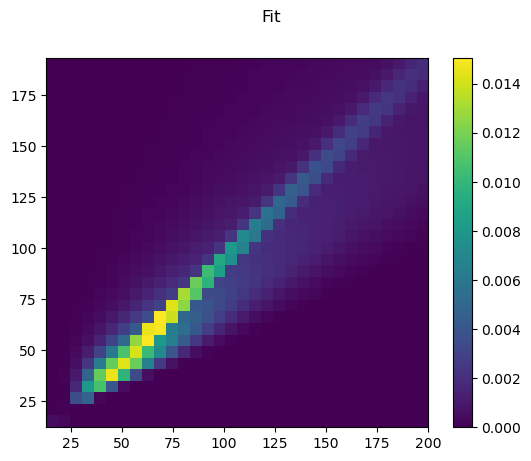

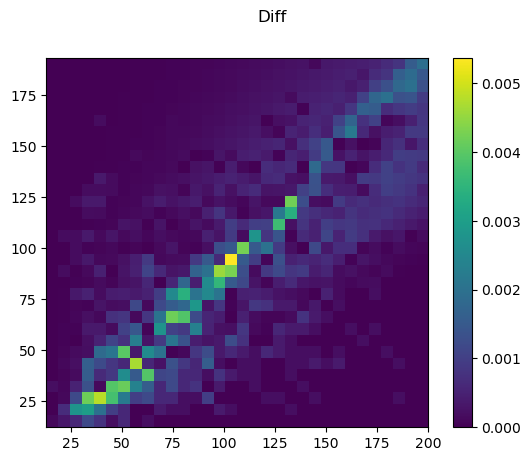

In [534]:
res2 = fit_jet_binned(data, 2)
good2 = res2.x.copy()

Optimization terminated successfully.
         Current function value: 0.000812
         Iterations: 4281
         Function evaluations: 6481
Optimization terminated successfully.
         Current function value: 0.002076
         Iterations: 2484
         Function evaluations: 3672


C:\Users\Bryan Bliewert\AppData\Local\Temp\ipykernel_4988\1326134499.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  c_result = minimize(f_binned, x0=make_guess(), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000895
         Iterations: 1534
         Function evaluations: 2285
Optimization terminated successfully.
         Current function value: 0.000797
         Iterations: 1905
         Function evaluations: 2841
Optimization terminated successfully.
         Current function value: 0.002778
         Iterations: 2761
         Function evaluations: 4058
Optimization terminated successfully.
         Current function value: 0.001379
         Iterations: 3878
         Function evaluations: 5630
Optimization terminated successfully.
         Current function value: 0.003104
         Iterations: 1861
         Function evaluations: 2673
Optimization terminated successfully.
         Current function value: 0.001520
         Iterations: 3067
         Function evaluations: 4502


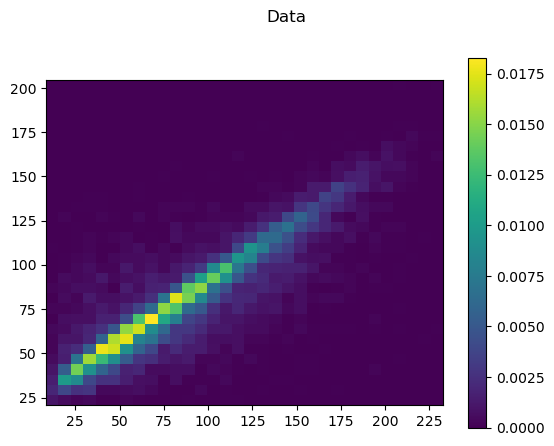

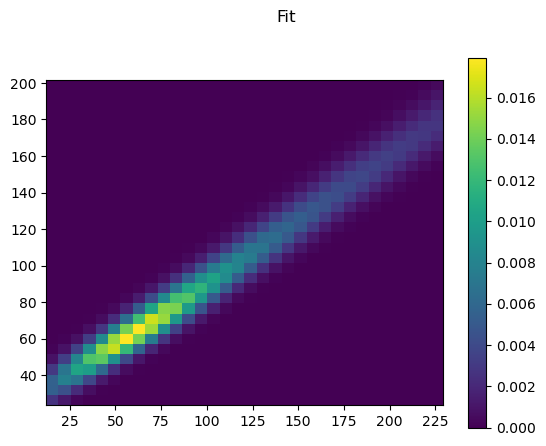

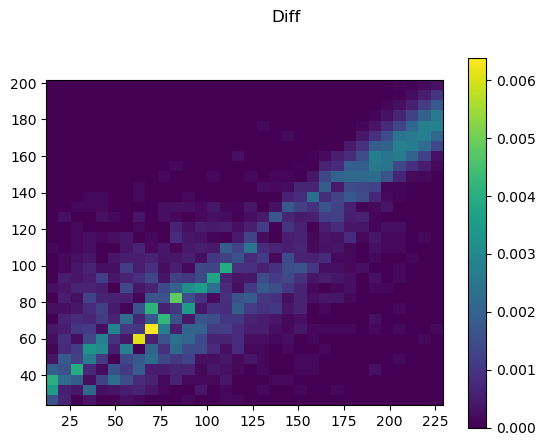

In [537]:
res3 = fit_jet_binned(data, 3)
good3 = res3.x.copy()

Optimization terminated successfully.
         Current function value: 0.001962
         Iterations: 1592
         Function evaluations: 2350


C:\Users\Bryan Bliewert\AppData\Local\Temp\ipykernel_4988\1326134499.py:101: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  c_result = minimize(f_binned, x0=make_guess(), method='Nelder-Mead', options={'maxiter': 1e4, 'maxfev': 1e4, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000823
         Iterations: 2877
         Function evaluations: 4139
Optimization terminated successfully.
         Current function value: 0.001577
         Iterations: 1403
         Function evaluations: 2130
Optimization terminated successfully.
         Current function value: 0.001785
         Iterations: 2389
         Function evaluations: 3829
Optimization terminated successfully.
         Current function value: 0.001455
         Iterations: 1791
         Function evaluations: 2639
Optimization terminated successfully.
         Current function value: 0.001230
         Iterations: 4989
         Function evaluations: 7162
Optimization terminated successfully.
         Current function value: 0.000861
         Iterations: 2679
         Function evaluations: 3931
Optimization terminated successfully.
         Current function value: 0.001986
         Iterations: 2230
         Function evaluations: 3632


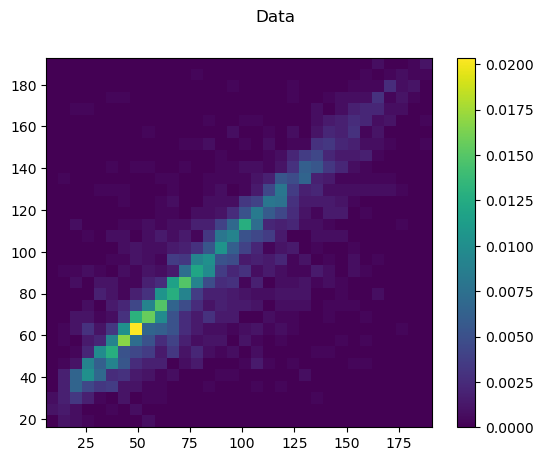

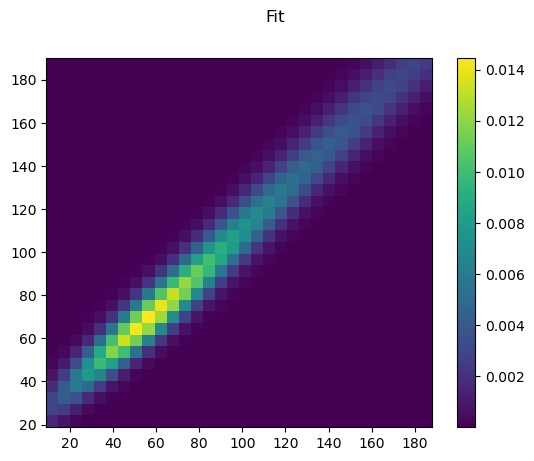

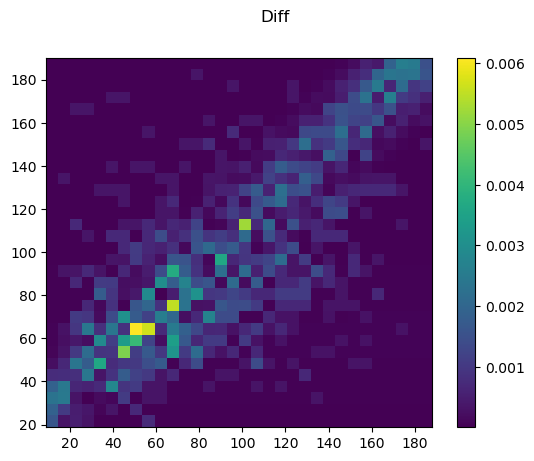

In [538]:
res4 = fit_jet_binned(data, 4)
good4 = res4.x.copy()

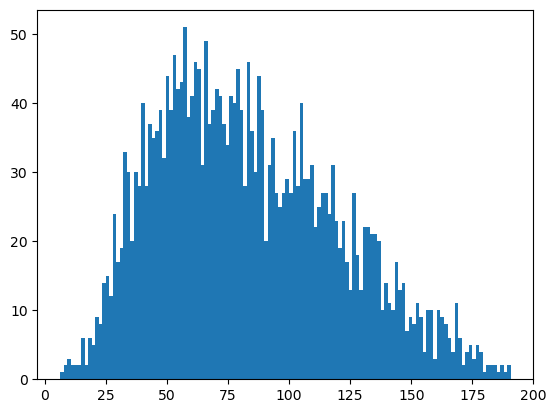

In [112]:
bin_count_j, bin_borders_j, _ = plt.hist(reco["jet1_e"], bins=128)

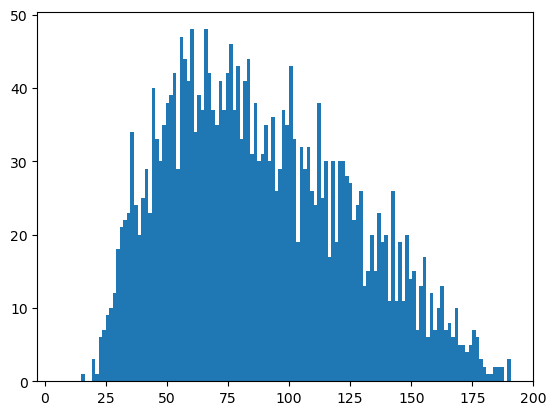

In [116]:
bin_count_p, bin_borders_p, _ = plt.hist(reco["parton1_e"], bins=bin_borders_j)

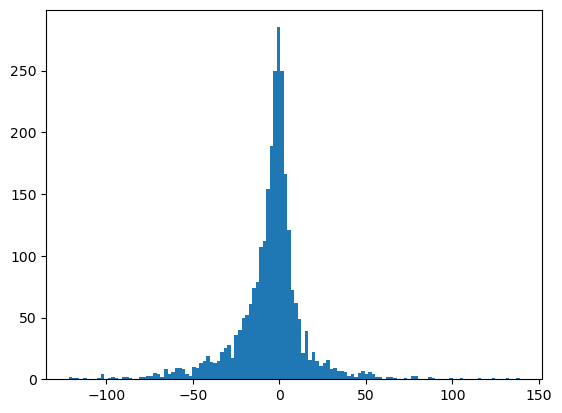

In [98]:
bin_count, bin_borders, _ = plt.hist(reco["jet1_e"] - reco["parton1_e"], bins=bin_borders_j)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2


In [ ]:
popt, _ = curve_fit(dbgauss_wrapped, (E_j, E_p), , p0=[])